### PB Deletions

* Deletions
* HG002 Only
* Technology: PB

* The following classifier will train on and predict the following labels:
    - GTcons
    
    
* All -1 values have been removed from the train and test set

In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from sklearn import preprocessing
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.charts import TimeSeries
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



***
Import Data
***

In [10]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/train/tech_sep/DEL/no_minus_one/pacbio_HG002_no-1_DEL.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/train/tech_sep/DEL/no_minus_one/pacbio_HG002_no-1_DEL.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,id,sample,start,end,type,SVtype,Size,refN_cnt,refN_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1,39,HG002,109690878,109690918,Insertion,Deletion,-39,0,0,...,222.0,197.0,11.0,9.0,20597.94118,5844.767921,17.0,12582.47059,3520.607336,17.0


In [11]:
train_set = pd.DataFrame()
train_set = df_train_2

In [12]:
train_set['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
train_set['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
train_set['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)

In [13]:
pd.value_counts(train_set['GTcons'].values, sort=False)

Homozygous_Reference    1176
Heterozygous_Variant     642
Homozygous_Variant       154
dtype: int64

**Note:**
    The original training set has 154 homozygous variant examples

In [14]:
# Train the model only on the rows that have an Exact Match or Homozygous Reference Label
# This step removes any row that has in 'Inaccurate Call' label
df_train = df_train[(df_train['Label'] == 1) | (df_train['Label'] == 0)]
df_train_2 = df_train_2[(df_train_2['Label'] == 1) | (df_train_2['Label'] == 0)]

In [15]:
pd.value_counts(df_train['Label'].values, sort=False)

0    685
1    535
dtype: int64

In [16]:
#(Copy Training Set) Train only on the rows that have an Exact Match or Homozygous Reference Label
# The following lists the count of EM, HR, Inaccurate Match Labels
pd.value_counts(df_train_2['Label'].values, sort=False)

0    685
1    535
dtype: int64

<a id='hom_ref'></a>

In [17]:
# List the consensus GT count (generated from R script) within the training set. Reminder! This dataset only includes svanalyzer Exact Match and Homozygous Reference datapoints only
pd.value_counts(df_train_2['GTcons'].values, sort=False)

Homozygous_Reference    669
Heterozygous_Variant    427
Homozygous_Variant      124
dtype: int64

In [18]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/test/tech_sep/DEL/no_minus_one/pacbio_HG002_no-1_DEL.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/test/tech_sep/DEL/no_minus_one/pacbio_HG002_no-1_DEL.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,id,sample,start,end,type,SVtype,Size,refN_cnt,refN_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,4,1,HG002,95498964,95499280,Deletion,Deletion,-316,0,0,...,215.0,255.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Label'}

In [20]:
### Drop columns that are not shared by both dataframes
df_train.drop(['Label'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [21]:
df_train.head(1)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1,109690878,109690918,-39,0,0,0,0.0,1,0.4,...,222.0,197.0,11.0,9.0,20597.94118,5844.767921,17.0,12582.47059,3520.607336,17.0


In [22]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [23]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict', 'GTsupp', 'SVtype', 'id', 'sample', 'type'}

In [24]:
### Drop columns that are not shared by both dataframes
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [25]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1,109690878,109690918,-39,0,0,0,0.000000,1,0.4,...,222.0,197.0,11.0,9.0,20597.94118,5844.767921,17.0,12582.47059,3520.607336,17.0
1,1,1869280,1869312,-31,0,0,0,0.000000,0,0.0,...,177.0,125.0,5.0,6.0,16622.10000,6461.411834,10.0,10433.70000,3505.460085,10.0
2,1,2891239,2891284,-44,0,0,1,0.666667,1,1.0,...,179.0,201.0,1.0,13.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0


In [26]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/1220 with 0 missing, elapsed time: 0.398
Imputing row 101/1220 with 0 missing, elapsed time: 0.399
Imputing row 201/1220 with 0 missing, elapsed time: 0.399
Imputing row 301/1220 with 0 missing, elapsed time: 0.400
Imputing row 401/1220 with 0 missing, elapsed time: 0.400
Imputing row 501/1220 with 0 missing, elapsed time: 0.401
Imputing row 601/1220 with 0 missing, elapsed time: 0.401
Imputing row 701/1220 with 0 missing, elapsed time: 0.402
Imputing row 801/1220 with 0 missing, elapsed time: 0.451
Imputing row 901/1220 with 0 missing, elapsed time: 0.451
Imputing row 1001/1220 with 0 missing, elapsed time: 0.452
Imputing row 1101/1220 with 0 missing, elapsed time: 0.452
Imputing row 1201/1220 with 0 missing, elapsed time: 0.453


In [27]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,1.0,109690878.0,109690918.0,-39.0,0.0,0.0,0.0,0.000000,1.0,0.4,...,222.0,197.0,11.0,9.0,20597.94118,5844.767921,17.0,12582.47059,3520.607336,17.0
1,1.0,1869280.0,1869312.0,-31.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,177.0,125.0,5.0,6.0,16622.10000,6461.411834,10.0,10433.70000,3505.460085,10.0
2,1.0,2891239.0,2891284.0,-44.0,0.0,0.0,1.0,0.666667,1.0,1.0,...,179.0,201.0,1.0,13.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0


In [28]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y['GTcons'] = X['GTcons']

In [29]:
#Count the number of labels
pd.value_counts(Y['GTcons'].values, sort=False)

1.0    427
2.0    124
0.0    669
dtype: int64

In [30]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [31]:
# Remove labels from feature set
X.drop(['GTcons'],axis=1, inplace = True)

In [32]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.

       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data. The trained model will be used in a [later section](#predict) to predict the consensus GT for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
       * In the following section, svanalyzer data was used to train a random forest (RF) model. The features for the svanalyzer dataset include: svviz features, GA4GH features [RefN, Segmental Duplications, Tandem Repeat], preliminary R script analysis [consensus GT, GTsup].
       * The RF classifier will predict the consensus GT labels:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
       
       * In the [following section](#prediction_step), the trained RF model will be used to predict labels for genotype labels for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]. 

** Train Random Forest Classifier **

<a id='train_test'></a>

In [33]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)

In [34]:
# %%timeit
# Train Random Forest Classifier
model = RandomForestClassifier() 
model.fit(X_train, y_train)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 5 (0.290156)
2. feature 8 (0.210269)
3. feature 9 (0.080270)
4. feature 7 (0.071467)
5. feature 3 (0.043643)
6. feature 6 (0.023884)
7. feature 20 (0.023385)
8. feature 12 (0.019432)
9. feature 19 (0.019049)
10. feature 11 (0.017917)
11. feature 22 (0.016557)
12. feature 16 (0.016073)
13. feature 2 (0.015490)
14. feature 24 (0.015482)
15. feature 13 (0.014365)
16. feature 10 (0.013881)
17. feature 29 (0.011915)
18. feature 23 (0.011462)
19. feature 0 (0.011331)
20. feature 4 (0.010753)
21. feature 18 (0.010713)
22. feature 14 (0.010482)
23. feature 15 (0.010133)
24. feature 21 (0.009354)
25. feature 1 (0.008740)
26. feature 17 (0.007289)
27. feature 28 (0.002213)
28. feature 30 (0.002135)
29. feature 31 (0.001407)
30. feature 27 (0.000750)
31. feature 25 (0.000000)
32. feature 26 (0.000000)


[Another Resource](https://stackoverflow.com/questions/37877542/how-to-label-the-feature-importance-with-forests-of-trees)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



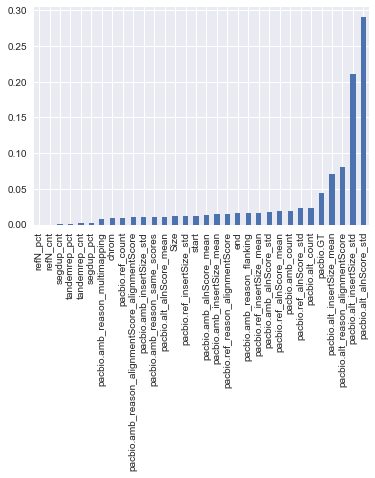

In [36]:
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feature_importances.sort()
feature_importances.plot.bar()

In [37]:
#TODO: Try training the model with the most important features and note difference in overal model prediction score

In [38]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

1.0    307
2.0     84
0.0    211
dtype: int64

<a id='prediction_step'></a>

In [39]:
model.predict(X_test)

array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        0.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,  1.,
        2.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1

In [40]:
pred = model.predict(X_test)

In [41]:
print('Precision score of the training subset: {:.3f}'.format(precision_score(pred, y_test, average='micro'))) 

Precision score of the training subset: 0.885


In [42]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,Size,chrom,end,pacbio.GT,pacbio.alt_alnScore_mean,pacbio.alt_alnScore_std,pacbio.alt_count,pacbio.alt_insertSize_mean,pacbio.alt_insertSize_std,pacbio.alt_reason_alignmentScore,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
1145,-68.0,8.0,116491119.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,...,11740.318180,4086.922596,22.0,0.0,0.0,0.0,0.0,116491050.0,2.0,0.536232
991,-39.0,4.0,180249288.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,...,9652.519231,3764.203228,52.0,0.0,0.0,0.0,0.0,180249248.0,0.0,0.000000
478,-31.0,8.0,36796498.0,2.0,15468.56410,7121.614675,39.0,9779.333333,4314.483249,39.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,36796466.0,1.0,1.000000
161,-26.0,15.0,64569961.0,1.0,18599.73913,7637.535695,23.0,11771.434780,4430.129528,23.0,...,11860.695650,4224.703740,23.0,0.0,0.0,0.0,0.0,64569934.0,0.0,0.000000
1154,-22.0,9.0,28512612.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,...,11141.822220,4379.624252,45.0,0.0,0.0,0.0,0.0,28512589.0,1.0,1.000000


In [43]:
labels = pd.DataFrame(y_test)

In [44]:
df_Xtest['predicted_label'] = pred
df_Xtest['GTcons'] = df_train['GTcons']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [45]:
df_Xtest['GTcons'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['GTcons'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['GTcons'].replace(2.0, 'Homozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [46]:
pd.value_counts(df_Xtest['GTcons'].values, sort=False)

Homozygous_Reference    214
Homozygous_Variant       40
Heterozygous_Variant    112
dtype: int64

In [47]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

Homozygous_Reference    214
Homozygous_Variant        9
Heterozygous_Variant    143
dtype: int64

In [48]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['GTcons']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[108   0   4]
 [  3 211   0]
 [ 32   3   5]]


In [49]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,108,0,4,112
Homozygous_Reference,3,211,0,214
Homozygous_Variant,32,3,5,40
All,143,214,9,366


**Reminder:** The original training set only inlcuded 154 [homozygous variant](#hom_ref) examples

In [50]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.76      0.96      0.85       112
Homozygous_Reference       0.99      0.99      0.99       214
  Homozygous_Variant       0.56      0.12      0.20        40

         avg / total       0.87      0.89      0.86       366



***
Predict
***

<a id='predict'></a>

Description:

   * In the [previous section](#machine_learning), a RF model was trained on svanalyzer data.

       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
 * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are the consensus genotype (GTcons) labels generated from a preliminary R analysis based on reference and alternate read count:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

** Load Data **

In [51]:
X2 = df_test

** Impute missing values using KNN **

In [52]:
#Convert dataframe to matrix
X2=X2.as_matrix()

#Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/3504 with 0 missing, elapsed time: 3.051
Imputing row 101/3504 with 0 missing, elapsed time: 3.052
Imputing row 201/3504 with 0 missing, elapsed time: 3.052
Imputing row 301/3504 with 0 missing, elapsed time: 3.052
Imputing row 401/3504 with 0 missing, elapsed time: 3.054
Imputing row 501/3504 with 0 missing, elapsed time: 3.055
Imputing row 601/3504 with 0 missing, elapsed time: 3.057
Imputing row 701/3504 with 0 missing, elapsed time: 3.057
Imputing row 801/3504 with 0 missing, elapsed time: 3.058
Imputing row 901/3504 with 0 missing, elapsed time: 3.058
Imputing row 1001/3504 with 0 missing, elapsed time: 3.061
Imputing row 1101/3504 with 0 missing, elapsed time: 3.063
Imputing row 1201/3504 with 0 missing, elapsed time: 3.063
Imputing row 1301/3504 with 0 missing, elapsed time: 3.065
Imputing row 1401/3504 with 0 missing, elapsed time: 3.067
Imputing row 1501/3504 with 0 missing, elapsed time: 3.068
Imputing row 1601/3504 with 0 missing, elapsed time: 3.068
Imputing 

In [53]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,4.0,95498964.0,95499280.0,-316.0,0.0,0.0,0.0,0.0,1.0,0.117089,...,215.0,255.0,0.0,12.0,0.0,0.000000,0.0,0.00,0.000000,0.0
1,19.0,14399929.0,14399954.0,-24.0,0.0,0.0,1.0,1.0,1.0,1.000000,...,128.0,163.0,0.0,9.0,14106.2,6697.022584,15.0,8671.60,3889.530045,15.0
2,8.0,76766532.0,76766569.0,-36.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,169.0,228.0,1.0,7.0,17009.9,6059.876145,20.0,10437.35,3673.796705,20.0


In [54]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,pacbio.amb_reason_alignmentScore_alignmentScore,pacbio.amb_reason_flanking,pacbio.amb_reason_multimapping,pacbio.amb_reason_same_scores,pacbio.ref_alnScore_mean,pacbio.ref_alnScore_std,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore
0,4.0,95498964.0,95499280.0,-316.0,0.0,0.0,0.0,0.0,1.0,0.117089,...,215.0,255.0,0.0,12.0,0.0,0.000000,0.0,0.00,0.000000,0.0
1,19.0,14399929.0,14399954.0,-24.0,0.0,0.0,1.0,1.0,1.0,1.000000,...,128.0,163.0,0.0,9.0,14106.2,6697.022584,15.0,8671.60,3889.530045,15.0
2,8.0,76766532.0,76766569.0,-36.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,169.0,228.0,1.0,7.0,17009.9,6059.876145,20.0,10437.35,3673.796705,20.0


In [55]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [56]:
model.predict(X5)

array([ 1.,  1.,  1., ...,  1.,  0.,  0.])

<a id='prediction_step'></a>

In [57]:
pred = model.predict(X5)

In [58]:
pred_prob = model.predict_proba(X5)

In [59]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTcons'] = df_test_2['GTcons']
X5['GTsupp'] = df_test_2['GTsupp']

In [60]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [61]:
X6.to_csv('PB_pred_prob_GTcons_DEL_SVanalyzer.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [62]:
X6 = pd.read_csv('/Users/lmc2/NIST/Notebooks/SVanalyzer_ML/DEL/results/PB/PB_pred_prob_GTcons_DEL_SVanalyzer.csv')

In [63]:
X6.rename(columns={'1': 'Homozygous_Reference'}, inplace=True)
X6.rename(columns={'2': 'Heterozygous_Variant'}, inplace=True)
X6.rename(columns={'3': 'Homozygous_Variant'}, inplace=True)
X6.rename(columns={'predicted_label': 'PB_predicted_label'}, inplace=True)

In [64]:
X6.head(3)

,Homozygous_Reference,Heterozygous_Variant,Homozygous_Variant,GTcons,GTsupp,Size,chrom,end,pacbio.GT,pacbio.alt_alnScore_mean,...,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,PB_predicted_label,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,0.0,1.0,0.0,2,1,-316,4,95499280,2.0,15367.42,...,0.000000,0.0,1,0,0,0,0.0,95498964,1,0.117089
1,0.0,0.9,0.1,1,1,-24,19,14399954,1.0,14568.25,...,3889.530045,15.0,1,0,0,1,1.0,14399929,1,1.000000
2,0.0,0.8,0.2,1,2,-36,8,76766569,1.0,17313.00,...,3673.796705,20.0,1,0,0,0,0.0,76766532,0,0.000000


In [65]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/results/PB_final_GTcons_df_DEL_SVanalyzer.csv', index=False)

***
Label Analysis
***

Description:
  * The [random forest(RF) model](#train_test) was trained on svanalyzer data. The trained model was used to predict consensus GT labels for the 5000 deletions that were randomly selected from the union_refalt vcf. The following is a comparison of model predicted labels [Conesus GT] to consensus genotype generated by the R script for the 5000 randomly selected datapoints from union_refalt.vcf 

In [66]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTcons']
predict = X6['PB_predicted_label']
print(confusion_matrix(consensus_GT, predict))

[[ 712  197   12]
 [  73 1772   67]
 [  12  602   57]]


In [67]:
X6['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)
X6['PB_predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
X6['PB_predicted_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
X6['PB_predicted_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [68]:
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,1772,73,67,1912
Homozygous_Reference,197,712,12,921
Homozygous_Variant,602,12,57,671
All,2571,797,136,3504


In [69]:
print('Precision score of the prediction subset: {:.3f}'.format(precision_score(consensus_GT, predict, average='micro'))) 

Precision score of the prediction subset: 0.725


** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following consensus genotype:
    * Homozygous Reference: 0 
    * Heterozygous Variant: 1 
    * Homozygous Variant: 2 
* Here **high confidence labels** are the labels predicted by the model that were also assigned a predict probability of either 0.9 or 1
* The following is an analysis of predicted svanalyzer labels with predict probability >0.9

In [70]:
high_conf_labels = X6[(X6['Homozygous_Reference'] == 1) | (X6['Homozygous_Reference'] == 0.9) | (X6['Heterozygous_Variant'] == 1) | (X6['Heterozygous_Variant'] == 0.9) | (X6['Homozygous_Variant'] == 1) | (X6['Homozygous_Variant'] == 0.9)]


In [72]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['PB_predicted_label']
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,513,31,1,545
Homozygous_Reference,40,617,0,657
Homozygous_Variant,213,6,0,219
All,766,654,1,1421


**NOTE:** There are only 2 Homozygous Reference examples. This may stem from the model being trained on 154 Hom Var examples. Next step, choose a training set with more Hom_Var examples

In [73]:
from sklearn.metrics import classification_report
print(classification_report(consensus_GT, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.67      0.94      0.78       545
Homozygous_Reference       0.94      0.94      0.94       657
  Homozygous_Variant       0.00      0.00      0.00       219

         avg / total       0.69      0.80      0.74      1421



***
Compare to crowdsourced results
***

#### PB: Crowdsourced (Crowdvariant) Results
![Figure1](https://raw.githubusercontent.com/lesleymaraina/NIST/master/Notebooks/SVanalyzer_ML/DEL/images/PB_CrowdVar1.png)

![Figure1](https://raw.githubusercontent.com/lesleymaraina/NIST/master/Notebooks/SVanalyzer_ML/DEL/images/PB_CrowdVar2.png)

![Figure1](https://raw.githubusercontent.com/lesleymaraina/NIST/master/Notebooks/SVanalyzer_ML/DEL/images/PB_CrowdVar3.png)